## Imports

In [14]:
import hub
from hub import Dataset, schema
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import img_as_ubyte
from glob import glob  
import tensorflow as tf
import random
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm

## Load data

In [15]:
#!export KAGGLE_USERNAME="xxxx" && export KAGGLE_KEY="xxx" && mkdir -p data && cd data && kaggle datasets download -d sorour/38cloud-cloud-segmentation-in-satellite-images && unzip -n 38cloud-cloud-segmentation-in-satellite-images.zip

In [16]:
!ls ./data/38cloud-cloud-segmentation-in-satellite-images

38-Cloud_95-Cloud_Test_Metadata_Files  38-Cloud_training
38-Cloud_Training_Metadata_Files       bibtex.txt
38-Cloud_test                          training_patches_38-cloud_nonempty.csv


In [17]:
!ls ./data/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training

Entire_scene_gts               train_nir
Natural_False_Color            train_red
train_blue                     training_patches_38-Cloud.csv
train_green                    training_sceneids_38-Cloud.csv
train_gt


In [18]:
dataset_path = "./data/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training"

In [19]:
def read_image(path):
    img = np.array(Image.open(path))
    return img 

def read_image_and_imshow(path):
    img = read_image(path)
    plt.imshow(img, cmap='gray')  
    plt.show()

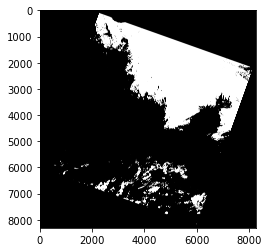

In [20]:
# Read first image ground truth "Entire Scene"
read_image_and_imshow(glob(dataset_path + "/Entire_scene_gts/*.TIF")[0])

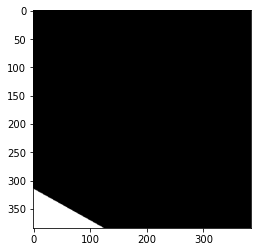

In [21]:
# Read first image ground truth "Patch" generated from the "Entire Scene"
read_image_and_imshow(glob(dataset_path + "/train_gt/*.TIF")[0])

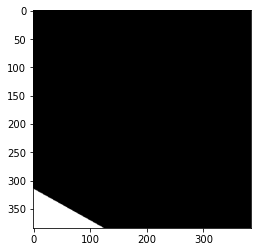

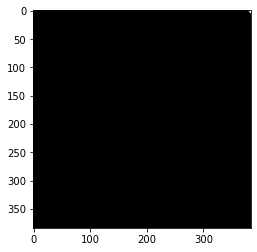

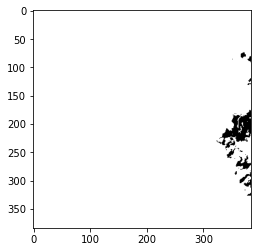

In [22]:
for i in range(3):
    read_image_and_imshow(glob(dataset_path + "/train_gt/*.TIF")[i])    

We see that some patches are empty. So we can use the csv file training_patches_38-cloud_nonempty.csv to only have non empty images

In [23]:
# Names of the training patches that are not empty
training_files = pd.read_csv("./data/38cloud-cloud-segmentation-in-satellite-images/training_patches_38-cloud_nonempty.csv")
training_files

,name
0,patch_100_5_by_12_LC08_L1TP_061017_20160720_20...
1,patch_100_5_by_12_LC08_L1TP_063016_20160920_20...
2,patch_100_5_by_12_LC08_L1TP_064014_20160420_20...
3,patch_100_5_by_12_LC08_L1TP_064017_20160420_20...
4,patch_100_5_by_12_LC08_L1TP_066017_20160520_20...
...,...
5150,patch_99_5_by_15_LC08_L1TP_045026_20160720_201...
5151,patch_99_5_by_15_LC08_L1TP_047023_20160920_201...
5152,patch_99_5_by_19_LC08_L1TP_002053_20160520_201...
5153,patch_99_5_by_19_LC08_L1TP_002054_20160520_201...


In [24]:
list_training_files = list(training_files.name)

patch_100_5_by_12_LC08_L1TP_061017_20160720_20170223_01_T1
Blue


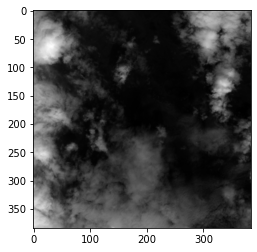

Green


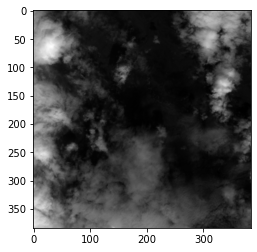

Red


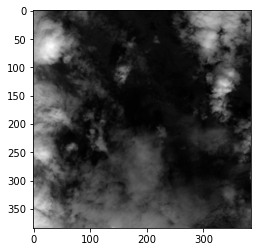

NIR


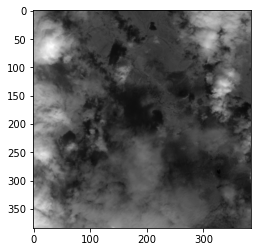

Ground truth


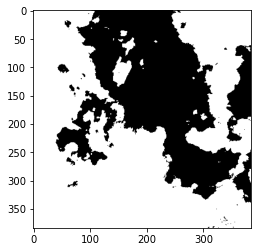

In [25]:
for image_name in list_training_files:
    print(image_name)
    print("Blue")
    read_image_and_imshow(f"{dataset_path}/train_blue/blue_{image_name}.TIF")  
    print("Green")
    read_image_and_imshow(f"{dataset_path}/train_green/green_{image_name}.TIF")
    print("Red")
    read_image_and_imshow(f"{dataset_path}/train_red/red_{image_name}.TIF")      
    print("NIR")
    read_image_and_imshow(f"{dataset_path}/train_nir/nir_{image_name}.TIF")    
    print("Ground truth")
    read_image_and_imshow(f"{dataset_path}/train_gt/gt_{image_name}.TIF")        
    break

## Combine all bands together and send np arrays to Hub

In [31]:
def combine_bands(dataset_path, image_path):
    path_red = f"{dataset_path}/train_red/red_{image_name}.TIF"
    path_green = f"{dataset_path}/train_green/green_{image_name}.TIF"
    path_blue = f"{dataset_path}/train_blue/blue_{image_name}.TIF"
    path_nir = f"{dataset_path}/train_nir/nir_{image_name}.TIF"
    path_gt = f"{dataset_path}/train_gt/gt_{image_name}.TIF"
    
    # Read images
    fnames = [path_red, path_green, path_blue, path_nir, path_gt]
    images = [read_image(fname) for fname in fnames]
    
    # Expand dimensions
    expanded_images = [np.expand_dims(img, axis=2) for img in images]
    
    # Combine red, blue, green and nir
    # concat
    img_combined = np.concatenate(expanded_images[:4], axis=2)
    gt = expanded_images[4]
    return img_combined, gt

In [32]:
img_combine_test = combine_bands(dataset_path, list_training_files[0]) 

In [33]:
img_combine_test[0].shape

(384, 384, 4)

In [34]:
img_combine_test[1].shape

(384, 384, 1)

In [35]:
assert img_combine_test[0].shape == (384, 384, 4) # should create an images with 4 bands and same size (384, 384)
assert img_combine_test[1].shape == (384, 384, 1) # Ground truth image

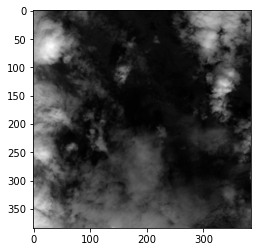

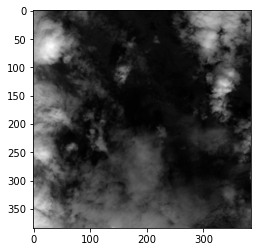

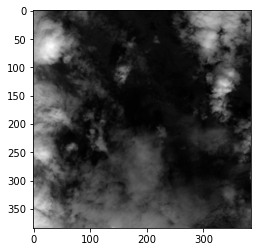

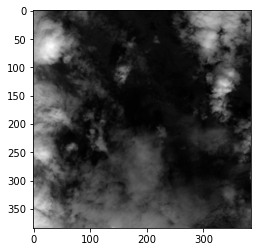

In [36]:
# # Check we have red, green, blue, nir
for i in range(img_combine_test[0].shape[2]):
    plt.imshow(img_combine_test[0][:,:,0], cmap="gray")
    plt.show()

In [19]:
list_all_combined_images = []
list_all_masks = []

# Loop through all the image paths in the taining csv file
for image_name in tqdm(list_training_files):
    img, mask = combine_bands(dataset_path, image_name)
    list_all_combined_images.append(img)
    list_all_masks.append(mask)


100%|██████████| 5155/5155 [01:38<00:00, 52.56it/s]


In [20]:
list_all_combined_images_np = np.array(list_all_combined_images)
print(list_all_combined_images_np.shape)
list_all_masks_np = np.array(list_all_masks)
print(list_all_masks_np.shape)

(5155, 384, 384, 4)
(5155, 384, 384, 1)


In [21]:
assert list_all_combined_images_np[0].shape == (384, 384, 4) # combined image
assert list_all_masks_np[0].shape == (384, 384, 1) # ground truth

## Send data (np arrays) to Hub

In [22]:
assert list_all_combined_images_np.shape[0] == list_all_masks_np.shape[0] 
list_all_combined_images_np.shape[0]

5155

In [23]:
tag = "margauxmforsythe/cloud-segmentation-dataset"

# Create dataset
ds = Dataset(
    tag,
    shape=(list_all_combined_images_np.shape[0],),
    schema={
        "image": schema.Tensor(list_all_combined_images_np[0].shape, dtype="float"),
        "mask": schema.Tensor(list_all_masks_np[0].shape, dtype="float")
    },
    mode="w+",
)

Your dataset is available at https://app.activeloop.ai/datasets/explore?tag=margauxmforsythe/cloud-segmentation-dataset


In [24]:
# # Upload Data -- This will take a lot of time 
ds["image"][:] = list_all_combined_images_np
ds["mask"][:] = list_all_masks_np

In [25]:
ds.commit()

'b90aea623ce7becf558ecb4564f024f29c3262ef'

In [26]:
# Load the data
print("Load data...")
ds = Dataset(tag)

Load data...


In [27]:
print(ds["image"][0].compute().shape)

(384, 384, 4)


In [28]:
len(ds)

5155

In [1]:
plt.imshow(ds["image"][0].compute()[:,:,0], cmap="gray")

NameError: name 'plt' is not defined